# Predicting potential whales in mobile games

Classification model to predict potential whales in mobile games based on user data during their first 7 days

In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # used for text report showing the main classification metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

### Importing the dataset

In [3]:
df = pd.read_csv('~/Documents/Model Analysis/Whales/Datasets/dataset_spender_7day.csv')
df_copy = df.copy()
df.pop("USERID")
df.head()

,TOTAL_TIME,AVG_SESS_TIME,VIP_PLAYED,TOURNAMENT_PLAYED,TOT_STARTS,NUM_DAYS,NUM_SESSIONS,BET_AMOUNT,D1_SPEND,MAX_PRICE,NUM_PURCHASES,FIRSTPAYMENT_FROMSTART,FIRST_AMOUNT,TOTAL_AMOUNT,WHALE
0,7811.960250,85.944119,0,0,81,8.0,21,500,0,0.00,0,0,0.00,0.00,0
1,2372.810033,37.075157,1,1,86,7.0,35,300,0,2.99,2,2,2.99,5.98,0
2,177.777300,8.465586,0,0,9,4.0,10,300,0,2.99,1,1,2.99,2.99,0
3,713.060317,13.204821,0,1,36,6.0,27,300,0,0.00,0,0,0.00,0.00,0
4,4296.651367,30.460390,1,1,97,8.0,39,300,1,19.99,2,0,19.99,20.98,0


### Correlation between target and values

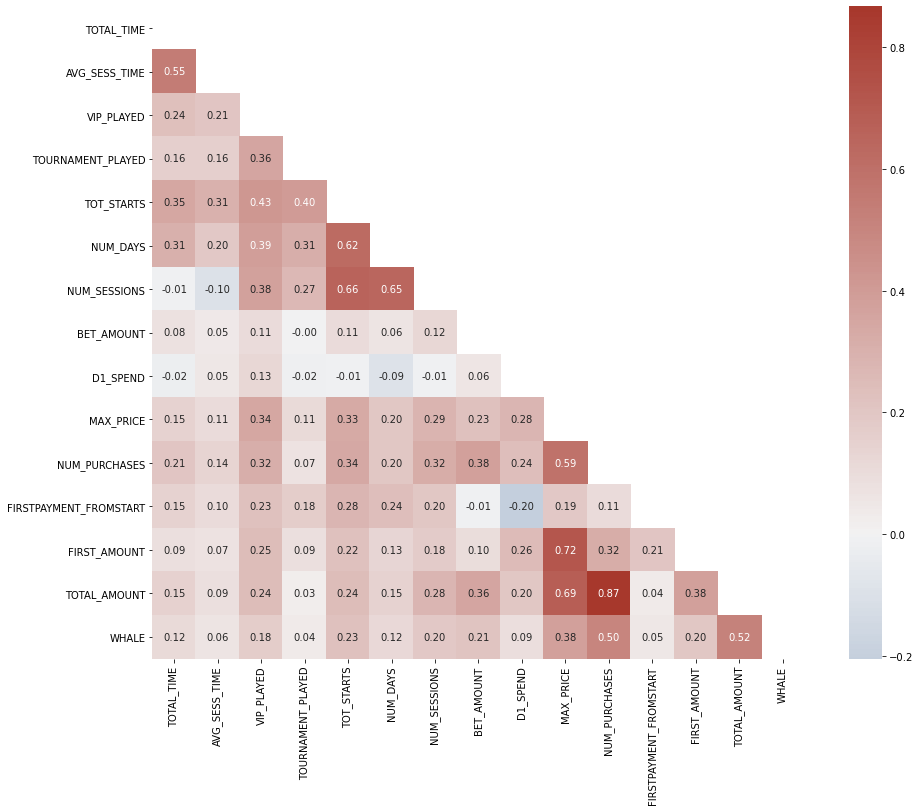

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
#get correlations of each features in dataset
corrmat = df.corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(corrmat, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();


In [5]:
cor_target = abs(corrmat["WHALE"])

#selecting only 'highly' correlate features
relevant_features = cor_target[cor_target > 0.2]
print(relevant_features)

X = df.iloc[:,0:14]
y = df.iloc[:,14]

TOT_STARTS       0.228084
BET_AMOUNT       0.210282
MAX_PRICE        0.380042
NUM_PURCHASES    0.503530
FIRST_AMOUNT     0.202010
TOTAL_AMOUNT     0.515778
WHALE            1.000000
Name: WHALE, dtype: float64
0        0
1        0
2        0
3        0
4        0
        ..
23871    0
23872    0
23873    0
23874    0
23875    0
Name: WHALE, Length: 23876, dtype: int64


## Hyperparameter tuning

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [7]:
classifier = xgb.XGBClassifier(tree_method='gpu_hist',gpu_id=0,use_label_encoder=False)

In [8]:
## Parameters

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9 ],
 "scale_pos_weight" : [1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13, 14]
}

### Running randomized search to find best hyperparameters

In [9]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=50,scoring='recall',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[16:58:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=0, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_j...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=50, n_jobs=-1,
          

In [10]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Building final model based on best estimators

In [11]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.02267	validation_0-logloss:0.49753	validation_1-error:0.03225	validation_1-logloss:0.50176
[1]	validation_0-error:0.01340	validation_0-logloss:0.37589	validation_1-error:0.01926	validation_1-logloss:0.38239
[2]	validation_0-error:0.00989	validation_0-logloss:0.29317	validation_1-error:0.01487	validation_1-logloss:0.30154
[3]	validation_0-error:0.00759	validation_0-logloss:0.23275	validation_1-error:0.01131	validation_1-logloss:0.24304
[4]	validation_0-error:0.00675	validation_0-logloss:0.18866	validation_1-error:0.01047	validation_1-logloss:0.20038
[5]	validation_0-error:0.00586	validation_0-logloss:0.15542	validation_1-error:0.00921	validation_1-logloss:0.16831
[6]	validation_0-error:0.00534	validation_0-logloss:0.12947	validation_1-error:0.00859	validation_1-logloss:0.14367
[7]	validation_0-error:0.00513	validation_0-logloss:0.11003	validation_1-error:0.00817	validation_1-logloss:0.12494
[8]	validation_0-error:0.00476	validation_0-logloss:0.09400	validation_1

[71]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[72]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[73]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[74]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[75]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[76]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[77]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[78]	validation_0-error:0.00073	validation_0-logloss:0.02149	validation_1-error:0.00670	validation_1-logloss:0.05064
[79]	validation_0-error:0.00073	validation_0-logloss:0.02149	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [12]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(model,X,y,cv=10)
score

[16:58:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:58:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.98994975, 0.99329983, 0.99329983, 0.99497487, 0.99455611,
       0.99204355, 0.99622958, 0.99329703, 0.99204022, 0.99287809])

## Final model scoring

In [13]:
score.mean()

0.9932568863027609

In [14]:
# making predictions
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
prc = average_precision_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("AUROC: %.2f%%" % (auc * 100.0))
print("AUPRC: %.2f%%" % (prc * 100.0))

Accuracy: 99.33%
Precision: 99.13%
Recall: 78.62%
AUROC: 89.30%
AUPRC: 78.59%


### Finding most important features for predicting whales

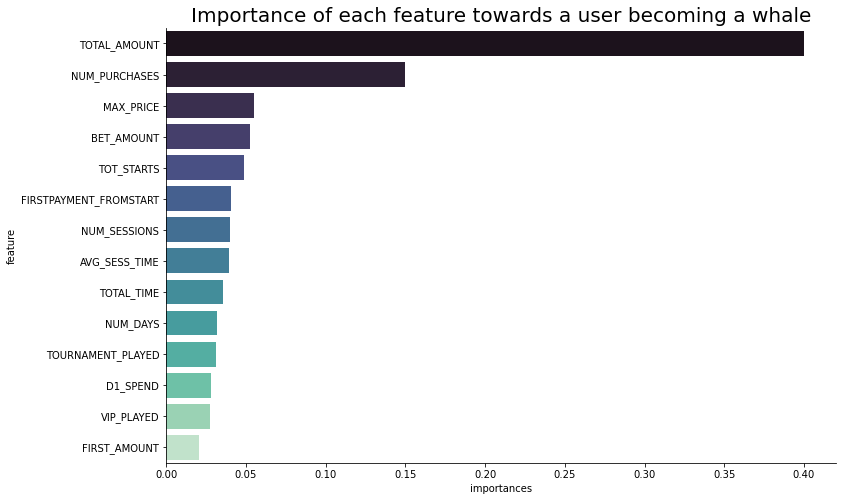

In [16]:
model.feature_importances_
importance = pd.DataFrame({'feature':X_train.columns, 'importances':model.feature_importances_ })
importance = importance.sort_values(by='importances', ascending=False)

fig = plt.figure(figsize=[12,8])
ax = sns.barplot(x='importances', y= 'feature', data=importance, palette = 'mako', orient = 'h')
ax.set_title("Importance of each feature towards a user becoming a whale", fontsize= 20)
sns.despine()

### Plotting ROC curve and Precision-recall curve to evaluate model fit

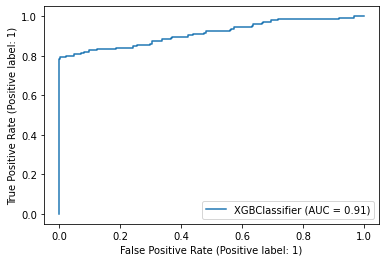

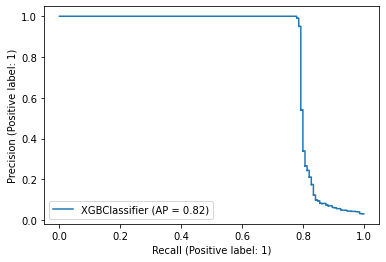

In [19]:
model_display = plot_roc_curve(model, X_test, y_test)
model_display2 = plot_precision_recall_curve(model, X_test, y_test)